In [20]:
import os, glob
import math, copy, time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm, trange

import numpy as np

import matplotlib
from matplotlib import pyplot as plt

from IPython.display import HTML
from IPython.display import display

from skeleton_models import ntu_rgbd, ntu_ss_1, ntu_ss_2, ntu_ss_3
from graph import Graph
from render import animate
from datasets import NTUDataset

# Model components
from zoo_pose_embedding import TwoLayersGCNPoseEmbedding
from zoo_action_encoder_units import TransformerEncoderUnit
from zoo_action_decoder_units import TransformerDecoderUnit
from zoo_upsampling import StepByStepUpsampling, JoaosUpsampling
from model import ActionEmbeddingTransformer
from layers import subsequent_mask

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
conf_kernel_size = adjacency.A.shape[0]
conf_num_nodes = adjacency.A.shape[1]
conf_heads = 5
conf_encoding_per_node = 50
conf_internal_per_node = int(conf_encoding_per_node/conf_heads)

class BetterThatBestModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = ActionEmbeddingTransformer(
            TwoLayersGCNPoseEmbedding(
                3,
                conf_encoding_per_node,
                conf_kernel_size
            ),
            TransformerEncoderUnit (
                heads=conf_heads,
                embedding_in=conf_num_nodes*conf_encoding_per_node,
                embedding_out=conf_num_nodes*conf_internal_per_node
            ),
            TransformerDecoderUnit(
                heads=conf_heads,
                embedding_in=conf_num_nodes*conf_encoding_per_node,
                embedding_out=conf_num_nodes*conf_internal_per_node,
                memory_in=conf_num_nodes*conf_encoding_per_node
            ),

            JoaosUpsampling(
                conf_num_nodes,
                conf_encoding_per_node*conf_num_nodes,
                node_channel_out = 3,
                device=device
            )
        )

    def forward(self, x_in, x_out, A, mask):
        return self.model(x_in, x_out, A, mask)

In [25]:


adjacency = Graph(ntu_rgbd)

A = torch.from_numpy(adjacency.A).to(device, dtype=torch.float)

model = BetterThatBestModel()

model.load_state_dict(torch.load('model_epoch_19.pth',  map_location=torch.device('cpu')))

model = model.to(device)

model.eval()


BetterThatBestModel(
  (model): ActionEmbeddingTransformer(
    (pose_embedding): TwoLayersGCNPoseEmbedding(
      (spatial_gcn_1): SpatialGCN(
        (conv): Conv2d(3, 36, kernel_size=(1, 1), stride=(1, 1))
      )
      (spatial_gcn_2): SpatialGCN(
        (conv): Conv2d(12, 150, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (action_encoder): EncoderStack(
      (encoder_units): ModuleList(
        (0): TransformerEncoderUnit(
          (self_attn): TemporalSelfAttention(
            (w_keys): ModuleList(
              (0): Linear(in_features=1250, out_features=250, bias=True)
              (1): Linear(in_features=1250, out_features=250, bias=True)
              (2): Linear(in_features=1250, out_features=250, bias=True)
              (3): Linear(in_features=1250, out_features=250, bias=True)
              (4): Linear(in_features=1250, out_features=250, bias=True)
            )
            (w_queries): ModuleList(
              (0): Linear(in_features=1250, out_features=250, b

In [3]:
ntu_dataset = NTUDataset(root_dir='../datasets/NTURGB-D/Python/raw_npy/')



In [26]:
sample_data = np.load('../datasets/NTURGB-D/Python/raw_npy/S003C001P008R002A023.skeleton.npy', allow_pickle=True)[()]
sample =  sample_data['skel_body0']
sample = torch.from_numpy(sample).to(device, dtype=torch.float)
sample = sample.unsqueeze(dim=0)
print(sample.size())

torch.Size([1, 83, 25, 3])


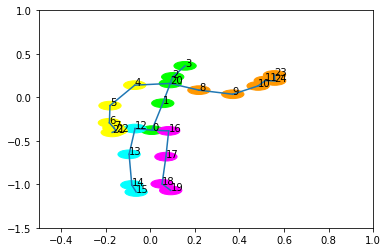

In [27]:
animate(sample[0], ntu_rgbd)

In [28]:
n_out, t_out, v_out, c_out = sample.size()
mask = subsequent_mask(t_out).to(device, dtype=torch.float)

out = model(sample, sample, A, mask)

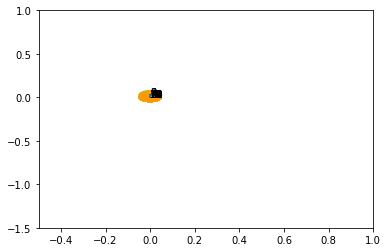

In [35]:
animate(out[0], ntu_rgbd)

In [32]:
criterion = torch.nn.MSELoss()

In [33]:
loss = criterion(out, sample)

In [34]:
loss

tensor(0.1781, grad_fn=<MseLossBackward>)